In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

In [ ]:
def Conv2D_Block(input_tensor , n_filters):
  x = tf.keras.layers.Conv2D(filters = n_filters , kernel_size = (3 , 3) , kernel_initializer = 'he_normal' , padding = 'same')(input_tensor)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  x = tf.keras.layers.Conv2D(filters = n_filters , kernel_size = (3 , 3) , kernel_initializer = 'he_normal' , padding = 'same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  return x

In [ ]:
val=0.2
def U_Net(img_tensor , n_filters = 3):
  conv1 = Conv2D_Block(img_tensor , n_filters * 1)
  pool1 = tf.keras.layers.MaxPooling2D((2 , 2))(conv1)
  pool1 = tf.keras.layers.Dropout(val)(pool1)

  conv2 = Conv2D_Block(pool1 , n_filters * 2)
  pool2 = tf.keras.layers.MaxPooling2D((2 , 2))(conv2)
  pool2 = tf.keras.layers.Dropout(val)(pool2)

  conv3 = Conv2D_Block(pool2 , n_filters * 4)
  pool3 = tf.keras.layers.MaxPooling2D((2 , 2))(conv3)
  pool3 = tf.keras.layers.Dropout(val)(pool3)

  conv4 = Conv2D_Block(pool3 , n_filters * 8)
  pool4 = tf.keras.layers.MaxPooling2D((2 , 2))(conv4)
  pool4 = tf.keras.layers.Dropout(val)(pool4)

  conv5 = Conv2D_Block(pool4 , n_filters * 16)

  pool6 = tf.keras.layers.Conv2DTranspose(n_filters * 8 , (3 , 3) , (2, 2) , padding = 'same')(conv5)
  pool6 = tf.keras.layers.concatenate([pool6 , conv4])
  pool6 = tf.keras.layers.Dropout(val)(pool6)
  conv6 = Conv2D_Block(pool6 , n_filters * 8)

  pool7 = tf.keras.layers.Conv2DTranspose(n_filters * 4 , (3 , 3) , (2 , 2) , padding = 'same')(conv6)
  pool7 = tf.keras.layers.concatenate([pool7 , conv3])
  pool7 = tf.keras.layers.Dropout(0.01)(pool7)
  conv7 = Conv2D_Block(pool7 , n_filters * 4)

  pool8 = tf.keras.layers.Conv2DTranspose(n_filters * 2 , (3 , 3) , (2 , 2) , padding = 'same')(conv7)
  pool8 = tf.keras.layers.concatenate([pool8 , conv2])
  pool8 = tf.keras.layers.Dropout(val)(pool8)
  conv8 = Conv2D_Block(pool8 , n_filters * 2)

  pool9 = tf.keras.layers.Conv2DTranspose(n_filters * 1 , (3 , 3) , (2 , 2) , padding = 'same')(conv8)
  pool9 = tf.keras.layers.concatenate([pool9 , conv1])
  pool9 = tf.keras.layers.Dropout(val)(pool9)
  conv9 = Conv2D_Block(pool9 , n_filters * 1)

  output = tf.keras.layers.Conv2D(1 , (1 , 1) , activation = 'sigmoid')(conv9)

  u_net = tf.keras.Model(inputs = [img_tensor] , outputs = [output])

  return u_net

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tejas1712","key":"9df5b2e4ba328c01ef93c9d7bcb2f259"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download --c ultrasound-nerve-segmentation

100% 2.11G/2.11G [01:46<00:00, 23.8MB/s]
100% 2.11G/2.11G [01:46<00:00, 21.3MB/s]


In [ ]:
!unzip ultrasound-nerve-segmentation.zip

In [ ]:
import pandas as pd
import os
import re

In [ ]:
H=128
W=128

In [ ]:
train_path = os.listdir('/content/train/')
test_path = os.listdir('/content/test/')

print(len(train_path) , len(test_path))

11270 5508


In [ ]:
reg = re.compile("[0-9]+")

temp1 = list(map(lambda x: reg.match(x).group(), train_path))
temp1 = list(map(int, temp1))

temp2 = list(map(lambda x: reg.match(x.split("_")[1]).group(), train_path))
temp2 = list(map(int, temp2))

train_path = [x for _,_,x in sorted(zip(temp1, temp2, train_path))]
train_path[:20]

In [ ]:
len(train_path)

11270

In [ ]:
train_image = []
train_mask = []

for index , item in enumerate(train_path):
  if index % 2 == 0:
    train_image.append(item)
  else:
    train_mask.append(item)

In [ ]:
print(len(train_image))
print(len(train_mask))

5635
5635


In [ ]:
import matplotlib.pyplot as plt
import random
from PIL import Image
import numpy as np
import skimage


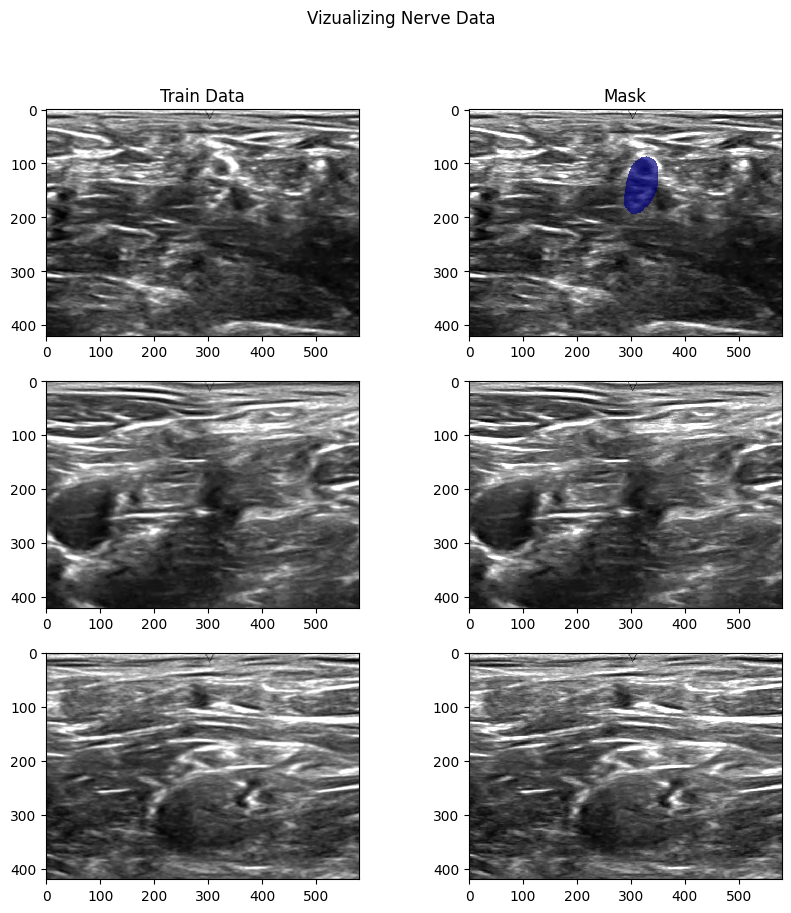

In [ ]:
fig , ax = plt.subplots(3 , 2 , figsize=[10 , 10])
fig.suptitle('Vizualizing Nerve Data')
ax[0 , 0].set_title('Train Data')
ax[0 , 1].set_title('Mask')

# print(ax.shape)
for i in range(0 , 3):
  ind = random.randint(0 , len(train_image))
  img1 = np.array(Image.open("/content/train/" + str(train_image[ind])))
  ax[i , 0].imshow(img1 , cmap = 'gray')

  img2 = np.array(Image.open("/content/train/" + str(train_mask[ind])))
  img2 = np.ma.masked_where(img2 == 0, img2)
  ax[i , 1].imshow(img1 , cmap = 'gray' , interpolation = 'none')
  ax[i , 1].imshow(img2 , cmap = 'jet', interpolation = 'none', alpha = 0.7)

plt.show()

In [ ]:
X = np.zeros((len(train_image), H, W, 1), dtype=np.float32)
y = np.zeros((len(train_image), H, W, 1), dtype=np.float32)

In [ ]:
for n , img_name in enumerate(train_image):
  img = tf.keras.preprocessing.image.load_img('/content/train/'+img_name , grayscale=True)
  in_img = tf.keras.preprocessing.image.img_to_array(img)
  in_img = skimage.transform.resize(in_img , (H , W , 1) , mode = 'constant' , preserve_range = True)
  X[n] = in_img / 255.0

for n , img_name in enumerate(train_mask):
  img = tf.keras.preprocessing.image.load_img('/content/train/'+img_name , grayscale=True)
  in_img = tf.keras.preprocessing.image.img_to_array(img)
  in_img = skimage.transform.resize(in_img , (H , W , 1) , mode = 'constant' , preserve_range = True)
  y[n] = in_img / 255.0

/usr/local/lib/python3.10/dist-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [ ]:
from sklearn.model_selection import train_test_split
X , X_test , y , y_test = train_test_split(X , y , test_size = 0.1 , random_state = 42)
X_train , X_valid , y_train , y_valid = train_test_split(X , y , test_size = 0.1 , random_state = 42)

In [ ]:
from keras import backend as K
def dice(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    coef = (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)
    return coef

def dice_loss(y_true, y_pred):
    loss = 1 - dice(y_true, y_pred)
    return loss

In [ ]:
img_tensor = tf.keras.layers.Input((H , W , 1) , name = 'img')
model = U_Net(img_tensor)
model.compile(optimizer = tf.keras.optimizers.Adam(),
            loss=dice_loss,
                  metrics=[dice])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 3)  30          ['img[0][0]']                    
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 3)  12         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=30, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=50, min_lr=0.00001, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/model_128*128.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = model.fit(X_train, y_train, batch_size=32, epochs=200, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/200
143/143 [==============================] - ETA: 0s - loss: 0.9678 - dice: 0.0322
Epoch 1: val_loss improved from inf to 0.97630, saving model to /content/drive/MyDrive/train_model_nerve_test_96_128.h5
143/143 [==============================] - 35s 57ms/step - loss: 0.9678 - dice: 0.0322 - val_loss: 0.9763 - val_dice: 0.0237 - lr: 0.0010
Epoch 2/200
143/143 [==============================] - ETA: 0s - loss: 0.9399 - dice: 0.0601
Epoch 2: val_loss did not improve from 0.97630
143/143 [==============================] - 5s 33ms/step - loss: 0.9399 - dice: 0.0601 - val_loss: 0.9804 - val_dice: 0.0196 - lr: 0.0010
Epoch 3/200
143/143 [==============================] - ETA: 0s - loss: 0.8846 - dice: 0.1155
Epoch 3: val_loss improved from 0.97630 to 0.93021, saving model to /content/drive/MyDrive/train_model_nerve_test_96_128.h5
143/143 [==============================] - 5s 33ms/step - loss: 0.8846 - dice: 0.1155 - val_loss: 0.9302 - val_dice: 0.0698 - lr: 0.0010
Epoch 4/200
143/14

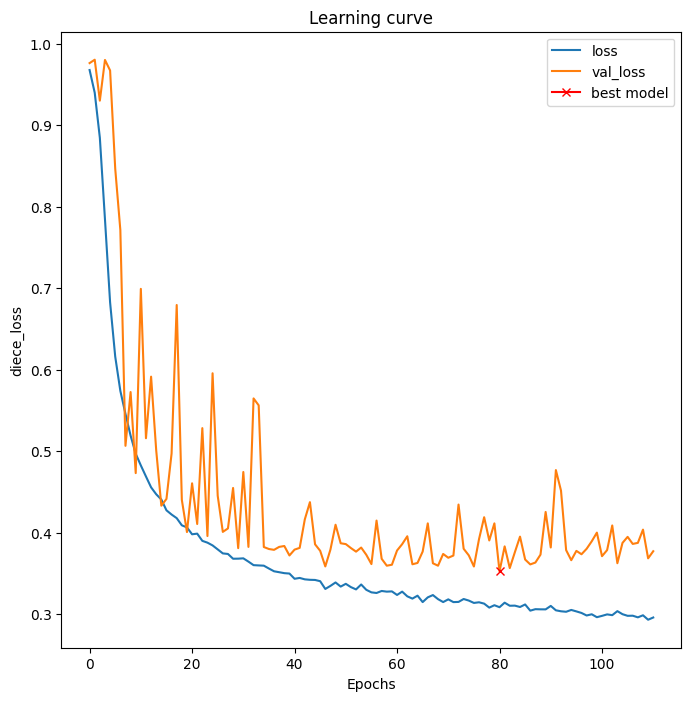

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("diece_loss")
plt.legend();

In [ ]:
model.load_weights('/content/drive/MyDrive/model_128*128.h5')

In [ ]:
global sum
bad=0
sum=0
def pred(count):
  prediction= model.predict(np.expand_dims( X_test[count], 0))
  '''
  fig , ax = plt.subplots(1 , 3)
  fig.suptitle('Vizualizing Nerve Data')
  ax[0].set_title('Test Image')
  ax[1].set_title('original maask')
  ax[2].set_title('Predicted Mask')
  '''
  img1 = X_test[count].squeeze()
  img3 = y_test[count].squeeze()
  #ax[0].imshow(img1 , cmap = 'gray')

  img2 = prediction.squeeze()
  img2 = np.ma.masked_where(img2 == 0, img2)
  #ax[0].imshow(img1 , cmap = 'gray' , interpolation = 'none')
  #ax[1].imshow(img3, cmap = 'gray' , interpolation = 'none')
  #ax[2].imshow(img2 , cmap = 'gray', interpolation = 'none')
  #ax[2].imshow(img2 ,cmap = 'gray', interpolation = 'none')
  #fil='/content/drive/MyDrive/pics/'
  #plt.savefig(fil+str(count)+'.png')
  #plt.show()
  x=tf.get_static_value(dice(img3,img2))
  print(x)
  return x

for i in range(len(X_test)):
  y=pred(i)
  if y>0.0 and y <0.1:
    bad+=1
  sum=sum+y
print("mean",sum/len(X_test))
print("bad",bad)

In [ ]:
global sum
sum=0
def pred(count):
  prediction= model.predict(np.expand_dims( X_train[count], 0))
  '''
  fig , ax = plt.subplots(1 , 3)
  fig.suptitle('Vizualizing Nerve Data')
  ax[0].set_title('Test Image')
  ax[1].set_title('original maask')
  ax[2].set_title('Predicted Mask')
  '''
  img1 = X_train[count].squeeze()
  img3 = y_train[count].squeeze()
  #ax[0].imshow(img1 , cmap = 'gray')

  img2 = prediction.squeeze()
  img2 = np.ma.masked_where(img2 == 0, img2)
  #ax[0].imshow(img1 , cmap = 'gray' , interpolation = 'none')
  #ax[1].imshow(img3, cmap = 'gray' , interpolation = 'none')
  #ax[2].imshow(img2 , cmap = 'gray', interpolation = 'none')
  #ax[2].imshow(img2 ,cmap = 'gray', interpolation = 'none')
  #fil='/content/drive/MyDrive/pics/'
  #plt.savefig(fil+str(count)+'.png')
  #plt.show()
  x=tf.get_static_value(dice(img3,img2))
  print(x)
  return x

for i in range(len(X_train)):
  y=pred(i)
  sum=sum+y
print("mean",sum/len(X_train))

In [ ]:
len(X_test)

564

In [ ]:
#prediction.squeeze().shape